In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Configuration
DATA_ROOTS = [
    # r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB",
    r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB"
]
BATCH_SIZE = 8
NUM_WORKERS = 0  # Optimize based on CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class ParkinsonSpectrogramDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        if isinstance(root_dirs, str):  # If a single path is given, convert it to a list
            root_dirs = [root_dirs]
        self.root_dirs = root_dirs
        self.transform = transform
        self.samples = self._load_samples()
        
    def _load_samples(self):
        samples = []
        for root_dir in self.root_dirs:
            for class_name in ['HC', 'PD']:
                class_dir = os.path.join(root_dir, class_name)
                if not os.path.exists(class_dir):
                    continue

                # Traverse subfolders inside HC/PD
                for patient_folder in os.listdir(class_dir):
                    patient_path = os.path.join(class_dir, patient_folder)
                    if os.path.isdir(patient_path):  # Ensure it's a directory
                        for img_file in os.listdir(patient_path):
                            if img_file.lower().endswith('.png'):  # Only PNG images
                                img_path = os.path.join(patient_path, img_file)
                                samples.append((img_path, 0 if class_name == 'HC' else 1))

        print(f"✅ Loaded {len(samples)} samples from {self.root_dirs}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        if self.transform:
            img = self.transform(img)
        return img, label

# Data Transforms
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Only slight translations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize between -1 and 1
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create Datasets (Loading from both MDVR & Italian datasets)
train_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'train') for root in DATA_ROOTS], transform=train_transform)
val_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'val') for root in DATA_ROOTS], transform=test_transform)
test_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'test') for root in DATA_ROOTS], transform=test_transform)

# Optimized DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ DataLoaders ready! Using device: {DEVICE}")

✅ Loaded 112988 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB/train']
✅ Loaded 24298 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB/val']
✅ Loaded 32957 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB/test']
✅ DataLoaders ready! Using device: cuda


In [2]:
# 🚀 Full Pipeline for Pretrained DenseNet121 with RGB Spectrograms

import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm import tqdm

# ============================
# ✅ Configuration
# ============================
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB"
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB"
# BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 50
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ✅ Data Transforms
# ============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize from (496x200) to 224x224 for DenseNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ============================
# ✅ Dataset and DataLoader
# ============================
# train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
# val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
# test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ============================
# ✅ Model Definition
# ============================
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# ============================
# ✅ Loss and Optimizer
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ============================
# ✅ Training and Validation Loop
# ============================
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        loop = tqdm(loader, desc="Validation", leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

# ============================
# ✅ Run Training
# ============================
for epoch in range(EPOCHS):
    print(f"\n🌟 Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)
    print(f"\n📈 Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

# ============================
# ✅ Testing
# ============================
def test_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"\n✅ Test Accuracy: {100. * correct / total:.2f}%")

# Run test
print("\n🚀 Testing best model...")
test_model(model, test_loader)



🌟 Epoch 1/50



📈 Train Loss: 0.1696, Acc: 0.9345 | Val Loss: 0.2014, Acc: 0.9188

🌟 Epoch 2/50



📈 Train Loss: 0.0913, Acc: 0.9662 | Val Loss: 0.1868, Acc: 0.9264

🌟 Epoch 3/50



📈 Train Loss: 0.0696, Acc: 0.9744 | Val Loss: 0.1299, Acc: 0.9472

🌟 Epoch 4/50



📈 Train Loss: 0.0595, Acc: 0.9784 | Val Loss: 0.1477, Acc: 0.9465

🌟 Epoch 5/50



📈 Train Loss: 0.0514, Acc: 0.9812 | Val Loss: 0.1250, Acc: 0.9567

🌟 Epoch 6/50



📈 Train Loss: 0.0451, Acc: 0.9832 | Val Loss: 0.1104, Acc: 0.9612

🌟 Epoch 7/50



📈 Train Loss: 0.0405, Acc: 0.9853 | Val Loss: 0.1633, Acc: 0.9515

🌟 Epoch 8/50



📈 Train Loss: 0.0374, Acc: 0.9865 | Val Loss: 0.1139, Acc: 0.9590

🌟 Epoch 9/50



📈 Train Loss: 0.0342, Acc: 0.9876 | Val Loss: 0.1095, Acc: 0.9600

🌟 Epoch 10/50



📈 Train Loss: 0.0312, Acc: 0.9888 | Val Loss: 0.1331, Acc: 0.9519

🌟 Epoch 11/50



📈 Train Loss: 0.0295, Acc: 0.9892 | Val Loss: 0.1721, Acc: 0.9448

🌟 Epoch 12/50



📈 Train Loss: 0.0272, Acc: 0.9903 | Val Loss: 0.1924, Acc: 0.9309

🌟 Epoch 13/50



📈 Train Loss: 0.0259, Acc: 0.9907 | Val Loss: 0.0946, Acc: 0.9666

🌟 Epoch 14/50



📈 Train Loss: 0.0245, Acc: 0.9912 | Val Loss: 0.1321, Acc: 0.9545

🌟 Epoch 15/50



📈 Train Loss: 0.0230, Acc: 0.9916 | Val Loss: 0.1090, Acc: 0.9670

🌟 Epoch 16/50



📈 Train Loss: 0.0222, Acc: 0.9921 | Val Loss: 0.1431, Acc: 0.9533

🌟 Epoch 17/50



📈 Train Loss: 0.0206, Acc: 0.9926 | Val Loss: 0.1275, Acc: 0.9631

🌟 Epoch 18/50



📈 Train Loss: 0.0209, Acc: 0.9924 | Val Loss: 0.0987, Acc: 0.9718

🌟 Epoch 19/50



📈 Train Loss: 0.0186, Acc: 0.9932 | Val Loss: 0.1908, Acc: 0.9510

🌟 Epoch 20/50



📈 Train Loss: 0.0180, Acc: 0.9932 | Val Loss: 0.0930, Acc: 0.9668

🌟 Epoch 21/50



📈 Train Loss: 0.0175, Acc: 0.9936 | Val Loss: 0.1118, Acc: 0.9636

🌟 Epoch 22/50



📈 Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.1033, Acc: 0.9668

🌟 Epoch 23/50



📈 Train Loss: 0.0164, Acc: 0.9942 | Val Loss: 0.1845, Acc: 0.9477

🌟 Epoch 24/50



📈 Train Loss: 0.0155, Acc: 0.9944 | Val Loss: 0.0624, Acc: 0.9813

🌟 Epoch 25/50



📈 Train Loss: 0.0148, Acc: 0.9945 | Val Loss: 0.1968, Acc: 0.9479

🌟 Epoch 26/50



📈 Train Loss: 0.0138, Acc: 0.9950 | Val Loss: 0.1535, Acc: 0.9502

🌟 Epoch 27/50



📈 Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.0651, Acc: 0.9788

🌟 Epoch 28/50



📈 Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1301, Acc: 0.9573

🌟 Epoch 29/50



📈 Train Loss: 0.0131, Acc: 0.9953 | Val Loss: 0.1669, Acc: 0.9537

🌟 Epoch 30/50



📈 Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.1156, Acc: 0.9673

🌟 Epoch 31/50



📈 Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.1242, Acc: 0.9621

🌟 Epoch 32/50



📈 Train Loss: 0.0116, Acc: 0.9957 | Val Loss: 0.1084, Acc: 0.9628

🌟 Epoch 33/50



📈 Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0686, Acc: 0.9780

🌟 Epoch 34/50



📈 Train Loss: 0.0114, Acc: 0.9957 | Val Loss: 0.0981, Acc: 0.9698

🌟 Epoch 35/50



📈 Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1210, Acc: 0.9641

🌟 Epoch 36/50



📈 Train Loss: 0.0107, Acc: 0.9959 | Val Loss: 0.0947, Acc: 0.9724

🌟 Epoch 37/50



📈 Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1034, Acc: 0.9695

🌟 Epoch 38/50



📈 Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0826, Acc: 0.9737

🌟 Epoch 39/50



📈 Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1194, Acc: 0.9611

🌟 Epoch 40/50



📈 Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1900, Acc: 0.9576

🌟 Epoch 41/50



📈 Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1528, Acc: 0.9611

🌟 Epoch 42/50



📈 Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0904, Acc: 0.9736

🌟 Epoch 43/50



📈 Train Loss: 0.0089, Acc: 0.9967 | Val Loss: 0.0935, Acc: 0.9778

🌟 Epoch 44/50



📈 Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.1243, Acc: 0.9585

🌟 Epoch 45/50



📈 Train Loss: 0.0095, Acc: 0.9965 | Val Loss: 0.1663, Acc: 0.9579

🌟 Epoch 46/50



📈 Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0901, Acc: 0.9749

🌟 Epoch 47/50



📈 Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.1206, Acc: 0.9671

🌟 Epoch 48/50



📈 Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1862, Acc: 0.9576

🌟 Epoch 49/50



📈 Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1334, Acc: 0.9628

🌟 Epoch 50/50



📈 Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1209, Acc: 0.9672

🚀 Testing best model...


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4120/4120 [06:15<00:00, 10.97it/s]


✅ Test Accuracy: 96.98%


In [4]:
# Save the trained model
torch.save(model.state_dict(), 'best_model5.pth')
print("✅ Model saved as 'best_model5.pth'")

✅ Model saved as 'best_model5.pth'


In [13]:
import numpy as np

# Arrays from log (50 epochs)
train_loss = np.array([
    0.1696, 0.0913, 0.0696, 0.0595, 0.0514, 0.0451, 0.0405, 0.0374, 0.0342, 0.0312,
    0.0295, 0.0272, 0.0259, 0.0245, 0.0230, 0.0222, 0.0206, 0.0209, 0.0186, 0.0180,
    0.0175, 0.0171, 0.0164, 0.0155, 0.0148, 0.0138, 0.0147, 0.0134, 0.0131, 0.0130,
    0.0123, 0.0116, 0.0115, 0.0114, 0.0103, 0.0107, 0.0111, 0.0102, 0.0102, 0.0099,
    0.0100, 0.0091, 0.0089, 0.0092, 0.0095, 0.0090, 0.0084, 0.0083, 0.0081, 0.0079
])

train_acc = np.array([
    0.9345, 0.9662, 0.9744, 0.9784, 0.9812, 0.9832, 0.9853, 0.9865, 0.9876, 0.9888,
    0.9892, 0.9903, 0.9907, 0.9912, 0.9916, 0.9921, 0.9926, 0.9924, 0.9932, 0.9932,
    0.9936, 0.9939, 0.9942, 0.9944, 0.9945, 0.9950, 0.9948, 0.9953, 0.9953, 0.9954,
    0.9956, 0.9957, 0.9959, 0.9957, 0.9964, 0.9959, 0.9962, 0.9963, 0.9964, 0.9964,
    0.9965, 0.9968, 0.9967, 0.9966, 0.9965, 0.9969, 0.9969, 0.9970, 0.9973, 0.9973
])

val_loss = np.array([
    0.2014, 0.1868, 0.1299, 0.1477, 0.1250, 0.1104, 0.1633, 0.1139, 0.1095, 0.1331,
    0.1721, 0.1924, 0.0946, 0.1321, 0.1090, 0.1431, 0.1275, 0.0987, 0.1908, 0.0930,
    0.1118, 0.1033, 0.1845, 0.0624, 0.1968, 0.1535, 0.0651, 0.1301, 0.1669, 0.1156,
    0.1242, 0.1084, 0.0686, 0.0981, 0.1210, 0.0947, 0.1034, 0.0826, 0.1194, 0.1900,
    0.1528, 0.0904, 0.0935, 0.1243, 0.1663, 0.0901, 0.1206, 0.1862, 0.1334, 0.1209
])

val_acc = np.array([
    0.9188, 0.9264, 0.9472, 0.9465, 0.9567, 0.9612, 0.9515, 0.9590, 0.9600, 0.9519,
    0.9448, 0.9309, 0.9666, 0.9545, 0.9670, 0.9533, 0.9631, 0.9718, 0.9510, 0.9668,
    0.9636, 0.9668, 0.9477, 0.9813, 0.9479, 0.9502, 0.9788, 0.9573, 0.9537, 0.9673,
    0.9621, 0.9628, 0.9780, 0.9698, 0.9641, 0.9724, 0.9695, 0.9737, 0.9611, 0.9576,
    0.9611, 0.9736, 0.9778, 0.9585, 0.9579, 0.9749, 0.9671, 0.9576, 0.9628, 0.9672
])

# np.save("train_loss.npy", train_loss)
# np.save("train_acc.npy", train_acc)
# np.save("val_loss.npy", val_loss)
# np.save("val_acc.npy", val_acc)

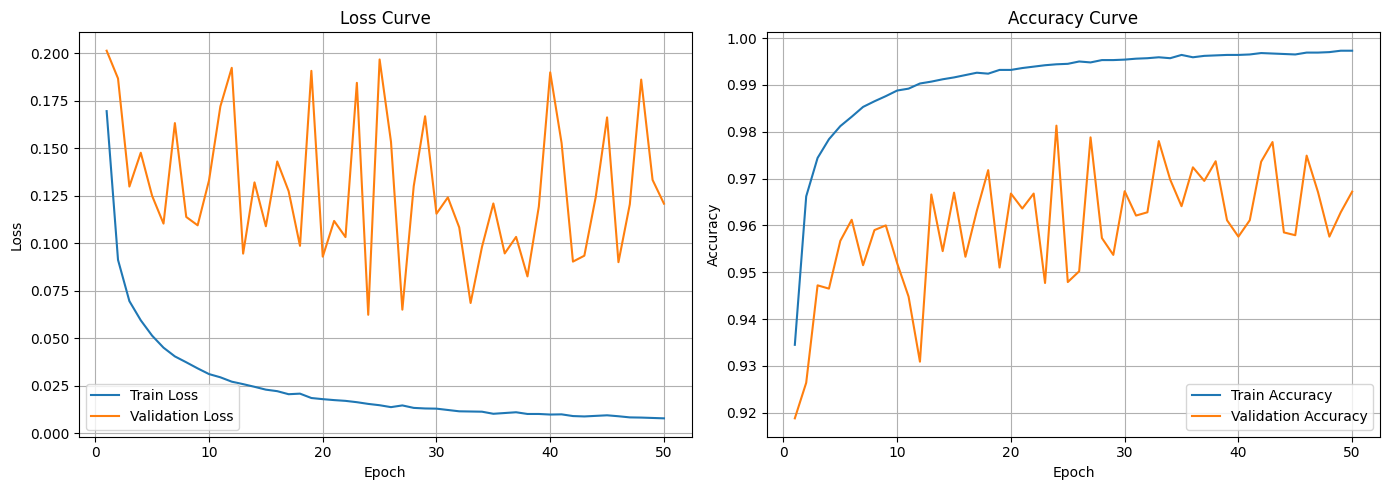

In [32]:
import matplotlib.pyplot as plt

epochs = np.arange(1, 51)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
import torchvision.models as models
import torch.nn as nn

NUM_CLASSES = 2

model5 = models.densenet121(weights=True)
model5.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
model5.load_state_dict(torch.load("best_model5.pth"))
model5.to(DEVICE)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def test_model5(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100. * correct / total
    print(f"\n✅ Test Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))



🚀 Testing best model...


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4120/4120 [06:04<00:00, 11.31it/s]



✅ Test Accuracy: 96.98%


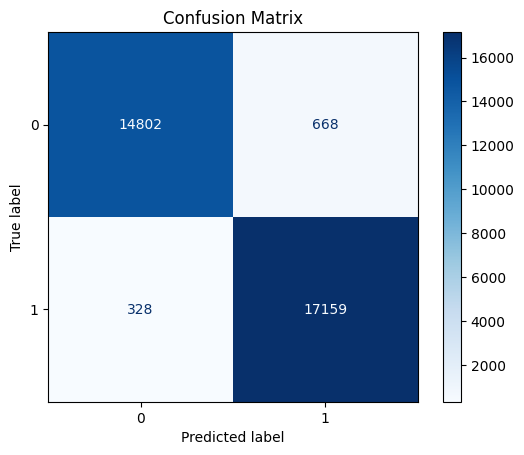


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9783    0.9568    0.9675     15470
           1     0.9625    0.9812    0.9718     17487

    accuracy                         0.9698     32957
   macro avg     0.9704    0.9690    0.9696     32957
weighted avg     0.9699    0.9698    0.9698     32957



In [36]:
print("\n🚀 Testing best model...")
test_model5(model5, test_loader)